<a href="https://colab.research.google.com/github/OCR-tech/AdaptDL/blob/main/examples/vision/ipynb/oxford_pets_image_segmentation3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

## Download the data

In [3]:
# !!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !
# !curl -O https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
# !curl -O https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz
# !
# !tar -xf images.tar.gz
# !tar -xf annotations.tar.gz

In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
import tensorflow as tf
print(tf.__version__)
print("gpu:", len(tf.config.experimental.list_physical_devices("GPU")))

2.18.0
gpu: 0


## Prepare paths of input images and target segmentation masks

In [6]:
# !ls

In [7]:
# !tar -xzvf "/content/drive/MyDrive/Colab_Notebooks/Colab2/images.tar.gz" -C "/content/drive/MyDrive/Colab_Notebooks/Colab2/images/"

In [8]:
# !tar -xzvf "/content/drive/MyDrive/Colab_Notebooks/Colab2/annotations.tar.gz" -C "/content/drive/MyDrive/Colab_Notebooks/Colab2/annotations/"

In [9]:
# !tar -xzvf "/content/drive/MyDrive/Colab_Notebooks/Colab2/annotations.tar.gz" -C "/content/drive/MyDrive/Colab_Notebooks/Colab2/annotations/"

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os

# input_dir = "images/"
# target_dir = "txt/"
input_dir = "/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/"
target_dir = "/content/drive/MyDrive/colab_notebooks/colab4_oxford/txt/"

img_size = (1360, 800)
# img_size = (160, 160)

num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)


for input_path, target_path in zip(input_img_paths[:800], target_img_paths[:800]):
    print(input_path, "|", target_path)


print("Number of input_img_paths:", len(input_img_paths))
print("Number of target_img_paths:", len(target_img_paths))

/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00000.jpg | /content/drive/MyDrive/colab_notebooks/colab4_oxford/txt/00000.png
/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00001.jpg | /content/drive/MyDrive/colab_notebooks/colab4_oxford/txt/00001.png
/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00002.jpg | /content/drive/MyDrive/colab_notebooks/colab4_oxford/txt/00002.png
/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00003.jpg | /content/drive/MyDrive/colab_notebooks/colab4_oxford/txt/00003.png
/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00004.jpg | /content/drive/MyDrive/colab_notebooks/colab4_oxford/txt/00004.png
/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00005.jpg | /content/drive/MyDrive/colab_notebooks/colab4_oxford/txt/00005.png
/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00006.jpg | /content/drive/MyDrive/colab_notebooks/colab4_oxford/txt/00006.png
/content/drive/MyDrive/cola

## What does one input image and corresponding segmentation mask look like?

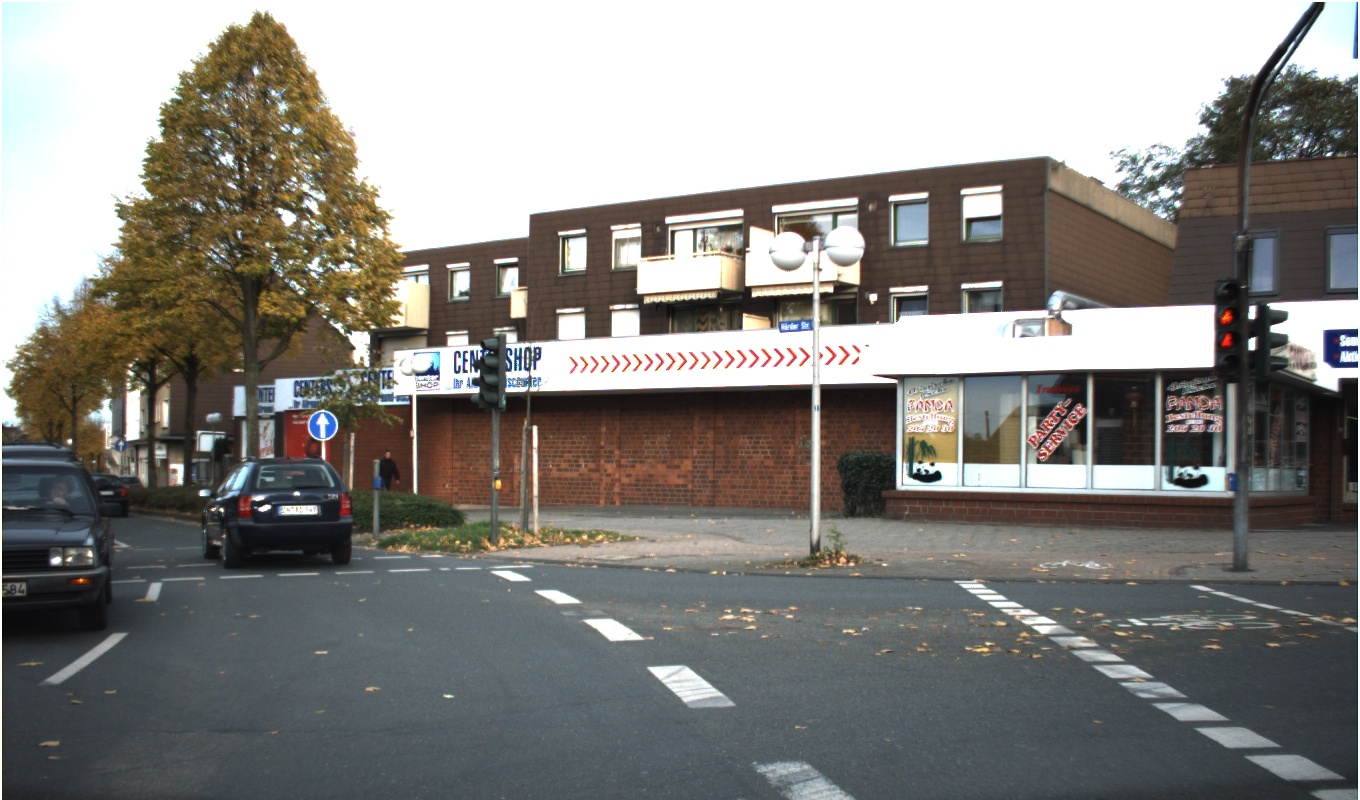

In [12]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[150]))

# Display auto-contrast version of corresponding target (per-pixel categories)
# img = ImageOps.autocontrast(load_img(target_img_paths[3]))
# display(img)

## Prepare dataset to load & vectorize batches of data

In [13]:
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io


def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

get_dataset(batch_size, img_size, input_img_paths, target_img_paths, max_dataset_len=50)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 1360, 800, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1360, 800, 1), dtype=tf.uint8, name=None))>

## Prepare U-Net Xception-style model

In [14]:
from keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model




In [15]:
# Build model
model = get_model(img_size, num_classes)
# model.summary()

## Set aside a validation split

In [16]:
import random

# Split our img paths into a training and a validation set
val_samples = 26
random.Random(13).shuffle(input_img_paths)
random.Random(13).shuffle(target_img_paths)

print("input_img_paths samples:", input_img_paths)
print("target_img_paths samples:", target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

print("val_input_img_paths samples:", val_input_img_paths)
print("val_target_img_paths samples:", val_target_img_paths)

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.



print("Batch size:", batch_size)
print("Input image size:", img_size)
print("train_input_img_paths samples:", len(train_input_img_paths),train_input_img_paths)
print("train_target_img_paths length:", len(train_target_img_paths),train_target_img_paths)


print("Number of target classes:", num_classes)
print("Steps per epoch:", len(train_input_img_paths) // batch_size)
print("Validation steps:", len(val_input_img_paths) // batch_size)

input_img_paths samples: ['/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00479.jpg', '/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00175.jpg', '/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00740.jpg', '/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00282.jpg', '/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00188.jpg', '/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00737.jpg', '/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00515.jpg', '/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00122.jpg', '/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00340.jpg', '/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00359.jpg', '/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00294.jpg', '/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00303.jpg', '/content/drive/MyDrive/colab_notebooks/colab4_oxford/images/00505.jpg', '/content/drive/MyDrive/c

In [17]:
# get_dataset(batch_size, img_size, input_img_paths, target_img_paths)

train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=50,
)

valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

In [18]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 1360, 800, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1360, 800, 1), dtype=tf.uint8, name=None))>

In [19]:
valid_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 1360, 800, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1360, 800, 1), dtype=tf.uint8, name=None))>

## Train the model

In [29]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.

model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
)


# model.compile(loss='binary_crossentropy',
#                 optimizer=keras.optimizers.Adam(),
#                 metrics=['accuracy'])


In [24]:
# Check lengths of training and test data generators
len(train_dataset)

2

In [ ]:
# Train the model, doing validation at the end of each epoch.
epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]



model.fit(
    train_dataset,
    epochs=epochs
    # validation_data=valid_dataset
    # callbacks=callbacks,
    # verbose=1,
    # verbose=2,
)


# model.fit(
#     train_dataset,
#     epochs=epochs,
#     validation_data=valid_dataset,
#     callbacks=callbacks,
#     # verbose=1,
#     # verbose=2,
# )

## Visualize predictions

In [ ]:
# Generate predictions for all images in the validation set

val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
val_preds = model.predict(val_dataset)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.